## Preprocessing

#### paste following lines into anaconda prompt (as admin) and press enter: 
#### conda install -c huggingface -c conda-forge datasets
#### conda install -c anaconda gensim


In [10]:
from datasets import load_dataset
import pandas as pd
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import numpy as np

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vince\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
#load the data set: text & labels [World (0), Sports (1), Business (2), Sci/Tech (3)]
dataset = load_dataset("ag_news")

Using custom data configuration default
Reusing dataset ag_news (C:\Users\vince\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 181.78it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

# Train test split and class distribution

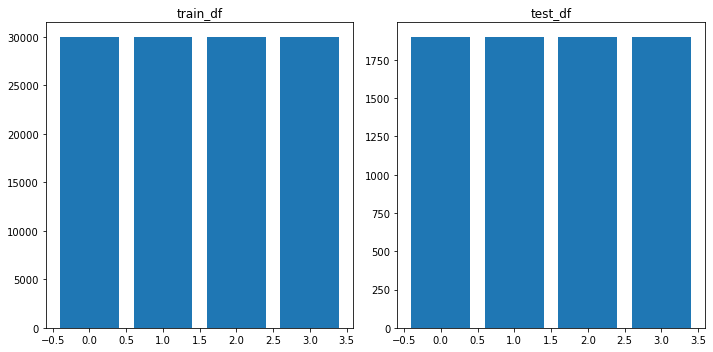

In [21]:
import matplotlib.pyplot as plt

# train test split
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])


# checking class distribution
plt.figure(figsize=(10,5))

## train data
plt.subplot(1,2,1)
train_df_target = train_df['label']
class_dist = pd.Series(train_df_target).value_counts()
plt.title('train_df')
plt.bar(class_dist.index, class_dist)
plt.tight_layout()

## test data
plt.subplot(1,2,2)
test_df_target = test_df['label']
class_dist = pd.Series(test_df_target).value_counts()
plt.title('test_df')
plt.bar(class_dist.index, class_dist)
plt.tight_layout()

plt.show()

In [4]:
#initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def preprocessing(text):
    
    # convert to lowercase and remove spaces at beginning and ending
    text = text.lower().strip()
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove html code
    text= re.sub('<.*?>', '', text) 
    
    # remove special characters
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove digits
    text = re.sub(r'\d',' ',text)
    
    # replace multiple whitespaces with one
    text = re.sub('\s+', ' ', text)
    
    # stop word removal
    clean_text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # tonkenize & lemmatize
    word_pos_tags = nltk.pos_tag(word_tokenize(clean_text)) # -> list of tuples (word, pos_tag) [('computer', 'NN'), ('word', 'tag')]
    lem_text = ' '.join([wnl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

    return lem_text

 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # default pos
        return wordnet.NOUN
    


In [6]:
# execute preprocessing for training set
train_df['text'] = train_df['text'].apply(lambda x: preprocessing(x))
train_df.to_csv('training_data.csv', sep=';', encoding='utf-8', index=False)
train_df.head()

KeyboardInterrupt: 

## Vectorization

In [3]:
# read in preprocessed training data if necessary
train_df = pd.read_csv('preprocessed_training_data.csv', sep=';', encoding='utf-8')
# for word embedding models
train_tokens = [word_tokenize(text) for text in train_df['text']]

### Count vectors and Tf-idf vectors

In [10]:
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(train_df['text'])
count_vectors = count_vectorizer.fit_transform(train_df['text'])

### Word2Vec SkipGram & CBOW

In [ ]:
w2v_cbow = Word2Vec(train_tokens, min_count=2, size=300, window=5)
w2v_skipg = Word2Vec(train_tokens, min_count=2, size=300, window=5, sg = 1)

In [ ]:
# returns mean w2v vector for list of specified words
def get_embedding(model, text):
    existing_words = [word for word in text if word in model.wv.vocab]
    if existing_words:
        embedding = np.zeros((len(existing_words), model.vector_size), dtype=np.float32)
        for i, w in enumerate(existing_words):
                embedding[i] = model.wv[w]
        return np.mean(embedding, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
# get mean vector for each article description for both models
embeddings_w2v_cbow = np.array([get_embedding(w2v_cbow, text) for text in train_tokens])
embeddings_w2v_skipg = np.array([get_embedding(w2v_skipg, text) for text in train_tokens])

### fastText

In [ ]:
fasttext = FastText(size=300, window=5, min_count=2)
fasttext.build_vocab(sentences=train_tokens)
fasttext.train(sentences=train_tokens, total_examples=len(train_tokens), epochs=10)

In [ ]:
embeddings_fasttext = np.array([get_embedding(fasttext, text) for text in train_tokens])

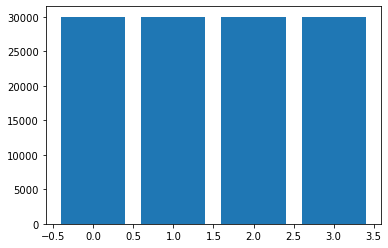